In [1]:
from pathlib import Path
from functools import partial

from utils import load_polar

import pybem as pb
import numpy as np
import pandas as pd

Inputs

In [2]:
PATH_POLARS = Path("../polars")
file_lift = "lift.csv"
file_drag = "drag.csv"
file_propeller = PATH_POLARS / "propeller1_inches.txt"

PITCH = 32.4  # inches

In [3]:
INCH_METER = 0.0254
PITCH = INCH_METER * PITCH # meters

In [4]:
csv_reader = partial(pd.read_csv, sep=";", index_col=None)
load_polar = partial(
    load_polar,
    path=PATH_POLARS,
    file_lift=file_lift,
    file_drag=file_drag,
    reader=csv_reader,
)

![Blade angle definition](figures/pitch_definition.png)

In [5]:
dimensions_df = pd.read_csv(filepath_or_buffer=file_propeller, sep=",")

# Enforce stripped columns
dimensions_df.columns = [col.strip() for col in dimensions_df.columns]
dimensions_df = dimensions_df[["radius", "chord"]]

# Convert to international units
INCH_METER = 0.0254
dimensions_df = dimensions_df.mul(INCH_METER)

# Name
dimensions_df.index = ["Hub", "S1", "S2", "S3", "S4", "Tip"]

for idx, row in dimensions_df.iterrows():

    r = row["radius"]

    tan_theta = PITCH / (2.0 * np.pi * r)
    theta = np.arctan(tan_theta)  # radians
    theta = np.rad2deg(theta)  # degrees

    dimensions_df.loc[idx, "theta"] = theta

dimensions_df

,radius,chord,theta
Hub,0.1016,0.06223,52.199199
S1,0.1778,0.06858,36.377590
S2,0.2540,0.06858,27.278439
S3,0.3302,0.06858,21.636400
S4,0.4064,0.06858,17.863548
Tip,0.4572,0.06858,15.985890


array([<AxesSubplot:xlabel='radius'>, <AxesSubplot:xlabel='radius'>],
      dtype=object)

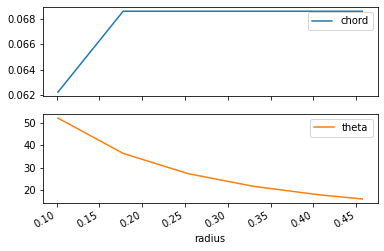

In [51]:
dimensions_df.set_index('radius').plot(subplots=True)

Create the blade by defining the sections at each stage. 

In [6]:
# Define known sections
sections = [
    pb.Section(
        name="Hub",
        r=dimensions_df.loc["Hub", "radius"],
        beta=dimensions_df.loc["Hub", "theta"],
        chord=dimensions_df.loc["Hub", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S1",
        r=dimensions_df.loc["S1", "radius"],
        beta=dimensions_df.loc["S1", "theta"],
        chord=dimensions_df.loc["S1", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S2",
        r=dimensions_df.loc["S2", "radius"],
        beta=dimensions_df.loc["S2", "theta"],
        chord=dimensions_df.loc["S2", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="764", which="cl"),
            polar_cd=load_polar(airfoil_type="764", which="cd"),
        ),
    ),
    pb.Section(
        name="S3",
        r=dimensions_df.loc["S3", "radius"],
        beta=dimensions_df.loc["S3", "theta"],
        chord=dimensions_df.loc["S3", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="763", which="cl"),
            polar_cd=load_polar(airfoil_type="763", which="cd"),
        ),
    ),
    pb.Section(
        name="S4",
        r=dimensions_df.loc["S4", "radius"],
        beta=dimensions_df.loc["S4", "theta"],
        chord=dimensions_df.loc["S4", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="762", which="cl"),
            polar_cd=load_polar(airfoil_type="762", which="cd"),
        ),
    ),
    pb.Section(
        name="Tip",
        r=dimensions_df.loc["Tip", "radius"],
        beta=dimensions_df.loc["Tip", "theta"],
        chord=dimensions_df.loc["Tip", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="762", which="cl"),
            polar_cd=load_polar(airfoil_type="762", which="cd"),
        ),
    ),
]

In [62]:
# Define propeller
B = 4
propeller = pb.Propeller(B=B, sections=sections)

# Define flow conditions and BEM method

results = []
for J in np.linspace(1e-1, 1.5):

    pi = np.pi

    _lambda = J / pi

    bem = pb.BladeElementMethod(
        _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
    )

    try:
        # Solve
        bem.solve()
        CT, CQ = bem.integrate_forces()
    except:
        CT = np.nan
        CQ = np.nan

    results.append(
        (J, CT * (pi ** 3.0) / 4 / J**2.0, CQ * (pi ** 4.0) / 4 / J**2.0, _lambda * CT / CQ)
    )

/opt/anaconda3/envs/pybem/lib/python3.8/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


In [63]:
results_df = (
    pd.DataFrame(results, columns=["J", "10.CT", "10.CP", "$\eta$"])
    .dropna()
    .set_index("J")
)

In [64]:
results_df

,10.CT,10.CP,$\eta$
J,,,
0.414286,0.568470,0.423644,0.555913
0.442857,0.483265,0.368450,0.580859
0.471429,0.413385,0.322581,0.604133
0.500000,0.355805,0.284285,0.625790
0.528571,0.307841,0.251878,0.646011
0.557143,0.267307,0.224042,0.664734
0.585714,0.232866,0.199901,0.682300
0.614286,0.203137,0.178659,0.698446
0.642857,0.177384,0.159910,0.713106


In [65]:
import matplotlib.pyplot as plt

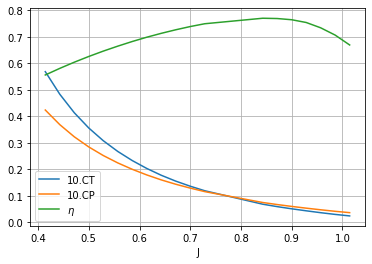

In [66]:
ax = results_df.plot()
ax.axis('tight');
ax.grid(True)